In [28]:
# import packages and add global parameter settings
import re
import json
import numpy as np
from io import StringIO
from tqdm.auto import tqdm
import wandb
import string
import nltk
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import FuncFormatter
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize


sb.set_theme(style="white", palette=None)

In [29]:
# connect to wandb and get list of runs
api_helper = wandb.Api(api_key='3138e1b24deb278ed045d0dedb39511d3a96245b')
runs = list(api_helper.runs(path='yuting_fyp/In-context-learning for Dialogue Summarization',
                     per_page=1000))
runs

[<Run yuting_fyp/In-context-learning+for+Dialogue+Summarization/3dh8hbgw (running)>,
 <Run yuting_fyp/In-context-learning+for+Dialogue+Summarization/jha105b9 (running)>,
 <Run yuting_fyp/In-context-learning+for+Dialogue+Summarization/xit0y9ko (running)>,
 <Run yuting_fyp/In-context-learning+for+Dialogue+Summarization/wrbutke3 (running)>,
 <Run yuting_fyp/In-context-learning+for+Dialogue+Summarization/mvap8e8p (running)>,
 <Run yuting_fyp/In-context-learning+for+Dialogue+Summarization/2qqw8dfu (crashed)>,
 <Run yuting_fyp/In-context-learning+for+Dialogue+Summarization/4nyombqt (crashed)>,
 <Run yuting_fyp/In-context-learning+for+Dialogue+Summarization/60rf5s2n (crashed)>,
 <Run yuting_fyp/In-context-learning+for+Dialogue+Summarization/3n4wgdn4 (crashed)>,
 <Run yuting_fyp/In-context-learning+for+Dialogue+Summarization/h050ncsy (running)>,
 <Run yuting_fyp/In-context-learning+for+Dialogue+Summarization/3maxent1 (crashed)>,
 <Run yuting_fyp/In-context-learning+for+Dialogue+Summarization/1

In [43]:
# iterate over completed runs to get ROUGE scores tables
run2metric_table = {}
for run in tqdm(runs):
    if 'complete' not in run.tags or 'evaluation' != getattr(run, 'job_type', ''):
        continue
    else:
        print('parsing run {}'.format(run.name))
    # download the rouge table
    files = run.files()
    metric_file = [file for file in files if 'Evaluation metrics Table' in getattr(file, 'name', '')]
    if len(metric_file) < 1:
        print('[WARN] skip {} because len(metric_file) < 1'.format(metric_file))
        continue
    metric_file = metric_file[0]
    f = metric_file.download(root='wandb', replace=True)
    metrics = json.load(f)
    metric_table = pd.read_json(json.dumps(metrics), orient='split')
    # get k shot
    try:
        match = re.search(r'\d-shot', run.name)
        start_i, end_i = match.span()
        k = int(run.name[start_i: end_i].split('-')[0])
        metric_table['k'] = k
    except AttributeError:
        print('[debug] skip {}'.format(run.name))
        continue 
    model_name = run.name[: start_i - 1]
    if run.name == 'Cerebras-6.7B-3-shot':
        metric_table['model_name'] = 'Cerebras-GPT-6.7B'
    else:
        metric_table['model_name'] = model_name
    if 'keyword' in run.name:
        end_id = run.name.find('-keyword')
        keyword_num = run.name[end_id - 1:end_id]
        metric_table['keyword_num'] = keyword_num
        print('[debug] find keyword_num = {} in {}'.format(keyword_num, run.name))
    else:
        metric_table['keyword_num'] = None

    run2metric_table[run.name] = metric_table
run2metric_table

  0%|          | 0/278 [00:00<?, ?it/s]

parsing run opt-1.3b-1-shot-focus
parsing run mt5-xl-3-shot-raw
parsing run opt-iml-1.3b-3-shot-focus
parsing run GPT3-davinci-003-2-shot-3-keywords
[debug] find keyword_num = 3 in GPT3-davinci-003-2-shot-3-keywords
parsing run GPT3-davinci-003-2-shot-3-keywords
[WARN] skip [] because len(metric_file) < 1
parsing run opt-iml-1.3b-2-shot-focus
parsing run opt-iml-1.3b-1-shot-focus
parsing run alpaca-native-1-shot-3-keywords
[debug] find keyword_num = 3 in alpaca-native-1-shot-3-keywords
parsing run GPT3-davinci-003-1-shot
parsing run alpaca-native-1-shot-2-keywords
[debug] find keyword_num = 2 in alpaca-native-1-shot-2-keywords
parsing run mt5-xl-1-shot-raw
parsing run glowing-violet-439
[debug] skip glowing-violet-439
parsing run Cerebras-GPT-2.7B-2-shot-length
parsing run Cerebras-GPT-2.7B-1-shot-length
parsing run llama-7b-hf-3-shot-length
parsing run llama-7b-hf-2-shot-length
parsing run llama-7b-hf-1-shot-length
parsing run Cerebras-GPT-2.7B-3-shot-length
parsing run opt-iml-1.3b-0

KeyboardInterrupt: 

# Direct prompt

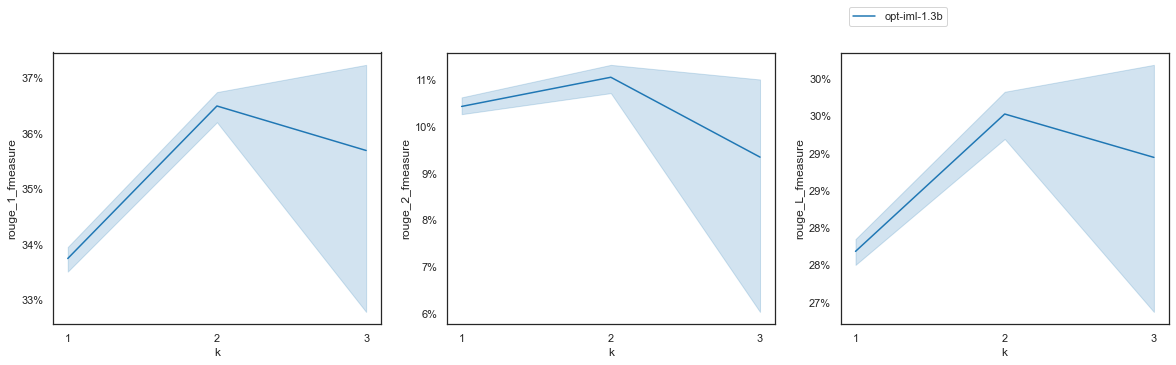

In [19]:
# parse the result of direct prompt
new_keys = [x for x in run2metric_table.keys() if ('keyword' not in x and 'nameReplace' not in x and 'length' 
                                                   not in x and 'replaceName' not in x and 'instructions' not in x)]
dfs = [run2metric_table[k] for k in new_keys]
rouge_table = pd.concat(dfs, axis=0, ignore_index=True)
rouge_table['k'] = rouge_table['k'].astype(int)
rouge_table['keyword_num'] = rouge_table['keyword_num'].fillna(0)
rouge_table = rouge_table[(rouge_table['k'] <= 3) & ~rouge_table.isna().any(axis=1)]
rouge_table = rouge_table[~rouge_table['model_name'].str.contains('Cerebras-GPT-6.7B') & ~rouge_table['model_name'].str.contains('flan-t5-xl')]

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

plot = sb.lineplot(data=rouge_table, x='k', y='rouge_1_fmeasure', hue='model_name', ax=axes[0], markers=True)
plot.set_xticks([1, 2, 3]) # <--- set the ticks first
plot.set_xticklabels(['1', '2', '3'])
axes[0].get_legend().remove()
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plot = sb.lineplot(data=rouge_table, x='k', y='rouge_2_fmeasure', hue='model_name', ax=axes[1], markers=True)
plot.set_xticks([1, 2, 3]) # <--- set the ticks first
plot.set_xticklabels(['1', '2', '3'])
axes[1].get_legend().remove()
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

plot = sb.lineplot(data=rouge_table, x='k', y='rouge_L_fmeasure', hue='model_name', ax=axes[2], markers=True)
plot.set_xticks([1, 2, 3]) # <--- set the ticks first
plot.set_xticklabels(['1', '2', '3'])
axes[2].get_legend().remove()
axes[2].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='right', ncol=3, bbox_to_anchor=(.75, 0.98))

plt.savefig('direct_prompt.jpg', dpi=500, bbox_inches='tight')

In [20]:
new_keys

['opt-iml-1.3b-3-shot-focus',
 'opt-iml-1.3b-2-shot-focus',
 'opt-iml-1.3b-1-shot-focus']

In [7]:
rouge_table.groupby(['model_name', 'k']).mean().to_csv('mean.csv')

In [8]:
rouge_table.groupby(['model_name', 'k']).std().to_csv('std.csv')

In [21]:
rouge_table.groupby(['model_name', 'k']).mean()

run_id  rouge_1_precision  rouge_1_recall  rouge_1_fmeasure  \
model_name   k                                                                
opt-iml-1.3b 1     2.0           0.269169        0.540900          0.337518   
             2     2.0           0.297256        0.558405          0.364942   
             3     1.5           0.295115        0.517734          0.356941   

                rouge_2_precision  rouge_2_recall  rouge_2_fmeasure  \
model_name   k                                                        
opt-iml-1.3b 1           0.082898        0.176748          0.104306   
             2           0.089707        0.176430          0.110534   
             3           0.077062        0.140824          0.093491   

                rouge_L_precision  rouge_L_recall  rouge_L_fmeasure  \
model_name   k                                                        
opt-iml-1.3b 1           0.221449        0.443471          0.276857   
             2           0.241322        0.450832          0.295308   
             3           0.240843        0.416431          0.289480   

                keyword_num  
model_name   k               
opt-iml-1.3b 1          0.0  
             2          0.0  
             3          0.0

In [22]:
rouge_table.groupby(['model_name', 'k']).std()

run_id  rouge_1_precision  rouge_1_recall  rouge_1_fmeasure  \
model_name   k                                                                  
opt-iml-1.3b 1  1.581139           0.003024        0.002615          0.002997   
             2  1.581139           0.003348        0.004760          0.003526   
             3  1.290994           0.027185        0.060567          0.029068   

                rouge_2_precision  rouge_2_recall  rouge_2_fmeasure  \
model_name   k                                                        
opt-iml-1.3b 1           0.002200        0.004262          0.002447   
             2           0.003792        0.004563          0.003873   
             3           0.028143        0.052776          0.033023   

                rouge_L_precision  rouge_L_recall  rouge_L_fmeasure  \
model_name   k                                                        
opt-iml-1.3b 1           0.002361        0.001918          0.002268   
             2           0.003898        0.005650          0.004260   
             3           0.017974        0.049343          0.020537   

                keyword_num  
model_name   k               
opt-iml-1.3b 1          0.0  
             2          0.0  
             3          0.0

# Plot results under controlled setting

[debug] new_keys = ['opt-1.3b-1-shot-focus']


C:\Users\chris\Desktop\CodeRepositories\venv\lib\site-packages\ipykernel_launcher.py:26: UserWarning: The palette list has more values (6) than needed (1), which may not be intended.
C:\Users\chris\Desktop\CodeRepositories\venv\lib\site-packages\ipykernel_launcher.py:30: UserWarning: The palette list has more values (6) than needed (1), which may not be intended.
C:\Users\chris\Desktop\CodeRepositories\venv\lib\site-packages\ipykernel_launcher.py:34: UserWarning: The palette list has more values (6) than needed (1), which may not be intended.


,run_id,rouge_1_precision,rouge_1_recall,rouge_1_fmeasure,rouge_2_precision,rouge_2_recall,rouge_2_fmeasure,rouge_L_precision,rouge_L_recall,rouge_L_fmeasure,k,model_name,keyword_num
0,0,0.363911,0.288617,0.284848,0.081540,0.063727,0.062255,0.280702,0.219694,0.216775,1,opt-1.3b,0
1,1,0.371076,0.285579,0.288244,0.078718,0.058996,0.058591,0.283340,0.214761,0.216600,1,opt-1.3b,0
2,2,0.360227,0.280055,0.281105,0.078534,0.057770,0.058656,0.277865,0.210748,0.212595,1,opt-1.3b,0
3,3,0.360793,0.283369,0.280458,0.072776,0.055978,0.055232,0.273194,0.211592,0.209912,1,opt-1.3b,0
4,4,0.367025,0.282539,0.286803,0.080636,0.058857,0.060496,0.279294,0.213093,0.216305,1,opt-1.3b,0


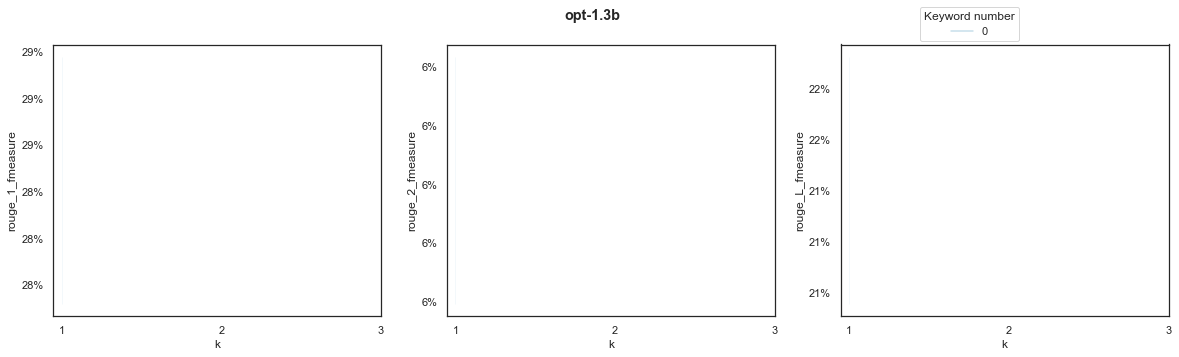

In [52]:
# get the result of MODEL_NAME family
MODEL_NAME = 'opt-1.3b'

if MODEL_NAME == 'mt5-xl':
    new_keys = [x for x in run2metric_table.keys() if MODEL_NAME in x and 'mt5-xxl' not in x]
else:
#     new_keys = [x for x in run2metric_table.keys() if MODEL_NAME in x and 'nameReplace' not in x and 'length' not in x and 'replaceName' not in x]
#     new_keys = [x for x in run2metric_table.keys() if MODEL_NAME in x and 'nameReplace' not in x and 'length' in x and 'replaceName' not in x]
    new_keys = [x for x in run2metric_table.keys() if MODEL_NAME in x and 'nameReplace' not in x and 'focus' in x and 'replaceName' not in x]

print('[debug] new_keys =', sorted(new_keys))
dfs = [run2metric_table[k] for k in new_keys]
rouge_table = pd.concat(dfs, axis=0, ignore_index=True)
model_name = rouge_table['model_name'].unique()[0]
rouge_table['k'] = rouge_table['k'].astype(int)
rouge_table['keyword_num'] = rouge_table['keyword_num'].fillna(0)
rouge_table['keyword_num'] = rouge_table['keyword_num'].astype(int)
rouge_table = rouge_table[~rouge_table.isna().any(axis=1)]

rouge_table = rouge_table[(rouge_table['k'] <= 3)]
# rouge_table = rouge_table[~rouge_table['model_name'].str.contains('Cerebras-GPT-6.7B')]

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
palette = sb.color_palette("ch:s=.25,rot=-.25", as_cmap=False)

plot = sb.lineplot(data=rouge_table, x='k', y='rouge_1_fmeasure', hue='keyword_num', ax=axes[0], markers=True, palette=palette)
plot.set_xticks([1, 2, 3]) # <--- set the ticks first
plot.set_xticklabels(['1', '2', '3'])
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plot = sb.lineplot(data=rouge_table, x='k', y='rouge_2_fmeasure', hue='keyword_num', ax=axes[1], markers=True, palette=palette)
plot.set_xticks([1, 2, 3]) # <--- set the ticks first
plot.set_xticklabels(['1', '2', '3'])
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plot = sb.lineplot(data=rouge_table, x='k', y='rouge_L_fmeasure', hue='keyword_num', ax=axes[2], markers=True, palette=palette)
plot.set_xticks([1, 2, 3]) # <--- set the ticks first
plot.set_xticklabels(['1', '2', '3'])
axes[2].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
axes[0].get_legend().remove()
axes[1].get_legend().remove()
axes[2].get_legend().remove()
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=5, bbox_to_anchor=(.8, 1), title='Keyword number')
fig.suptitle(model_name, fontweight='bold')
#
plt.savefig('{}_entity_control.jpg'.format(model_name), dpi=500, bbox_inches='tight')

rouge_table

In [50]:
mean_df = rouge_table.groupby('k').mean() * 100
mean_df[[x for x in mean_df.columns if 'fmeasure' in x]]

,rouge_1_fmeasure,rouge_2_fmeasure,rouge_L_fmeasure
k,,,
1,33.751845,10.430595,27.685666
2,36.494225,11.053376,29.530769
3,35.694119,9.349058,28.947957


In [51]:
std_df = rouge_table.groupby('k').std() * 100
std_df[[x for x in std_df.columns if 'fmeasure' in x]]

,rouge_1_fmeasure,rouge_2_fmeasure,rouge_L_fmeasure
k,,,
1,0.299711,0.244693,0.226770
2,0.352601,0.387331,0.425967
3,2.906761,3.302343,2.053686


In [46]:
run2metric_table.keys()

dict_keys(['opt-1.3b-1-shot-focus', 'mt5-xl-3-shot-raw', 'opt-iml-1.3b-3-shot-focus', 'GPT3-davinci-003-2-shot-3-keywords', 'opt-iml-1.3b-2-shot-focus', 'opt-iml-1.3b-1-shot-focus', 'alpaca-native-1-shot-3-keywords', 'GPT3-davinci-003-1-shot', 'alpaca-native-1-shot-2-keywords', 'mt5-xl-1-shot-raw', 'Cerebras-GPT-2.7B-2-shot-length', 'Cerebras-GPT-2.7B-1-shot-length', 'llama-7b-hf-3-shot-length', 'llama-7b-hf-2-shot-length', 'llama-7b-hf-1-shot-length', 'Cerebras-GPT-2.7B-3-shot-length', 'opt-iml-1.3b-0-shot-instructions', 'opt-iml-1.3b-2-shot-instructions', 'opt-iml-1.3b-3-shot-instructions', 'opt-iml-1.3b-1-shot-instructions', 'opt-iml-1.3b-1-shot-replaceName', 'opt-iml-1.3b-3-shot-replaceName', 'opt-iml-1.3b-2-shot-length', 'opt-iml-1.3b-1-shot-length', 'opt-iml-1.3b-3-shot-length', 'bloom-7b1-2-shot-replaceName', 'bloom-7b1-3-shot-replaceName', 'bloom-7b1-1-shot-replaceName', 'opt-1.3b-3-shot-replaceName', 'opt-1.3b-2-shot-nameReplace', 'opt-1.3b-1-shot-nameReplace', 'Cerebras-GPT-1

# Get Success Rate

In [34]:
# iterate over completed runs to get summaries table
MODEL_FAMILY = ['GPT3-davinci-003']

run2metric_table = {}
for run in tqdm(runs):
    if 'complete' not in run.tags or run.config['model_type'] not in MODEL_FAMILY or run.job_type != 'evaluation':
        continue
    if 'nameReplace' in run.name or 'length' in run.name or 'replaceName' in run.name:
        continue 
    print('parsing run {}'.format(run.name))
    files = run.files()
    metric_file = [file for file in files if 'Summaries Table' in getattr(file, 'name', '')]
    print([file.name for file in files])
    if len(metric_file) < 1:
        print('[WARN] skip {} because len(metric_file) >= 1'.format(metric_file))
        continue 
    metric_file = metric_file[0]
    f = metric_file.download(root='wandb', replace=True)
    metrics = json.load(f)
    metrics = json.dumps(metrics)
    metric_table = pd.read_json(StringIO(metrics), orient='split')
    # get k shot
    match = re.search(r'\d-shot', run.name)
    start_i, end_i = match.span()
    k = int(run.name[start_i: end_i].split('-')[0])

    metric_table['k'] = k
    model_name = run.name[: start_i - 1]
    metric_table['model_name'] = model_name
    if 'keyword' in run.name:
        end_id = run.name.find('-keyword')
        keyword_num = run.name[end_id - 1:end_id]
        metric_table['keyword_num'] = keyword_num
        print('[debug] find keyword_num = {} in {}'.format(keyword_num, run.name))
    else:
        metric_table['keyword_num'] = None

    run2metric_table[run.name] = metric_table
run2metric_table

  0%|          | 0/278 [00:00<?, ?it/s]

parsing run GPT3-davinci-003-2-shot-3-keywords
['artifact/486825664/wandb_manifest.json', 'artifact/486825683/wandb_manifest.json', 'config.yaml', 'media/table/Evaluation metrics Table_0_7ade0fd99cbd0cb328dc.table.json', 'media/table/Summaries Table_1_8abbff941093fa180ae0.table.json', 'output.log', 'requirements.txt', 'wandb-metadata.json', 'wandb-summary.json']
[debug] find keyword_num = 3 in GPT3-davinci-003-2-shot-3-keywords
parsing run GPT3-davinci-003-2-shot-3-keywords
['wandb-metadata.json']
[WARN] skip [] because len(metric_file) >= 1
parsing run GPT3-davinci-003-1-shot
['artifact/485943481/wandb_manifest.json', 'artifact/485943497/wandb_manifest.json', 'config.yaml', 'media/table/Evaluation metrics Table_0_a0920e44cd1f211a6aae.table.json', 'media/table/Summaries Table_1_16d8e2f89e7007146221.table.json', 'output.log', 'requirements.txt', 'wandb-metadata.json', 'wandb-summary.json']


{'GPT3-davinci-003-2-shot-3-keywords':      run_id                                             prompt  \
 0         0  Summarize the conversation with keywords:\nJoh...   
 1         0  Summarize the conversation with keywords:\nLis...   
 2         0  Summarize the conversation with keywords:\nLar...   
 3         0  Summarize the conversation with keywords:\nLol...   
 4         0  Summarize the conversation with keywords:\nRob...   
 ..      ...                                                ...   
 813       0  Summarize the conversation with keywords:\nTom...   
 814       0  Summarize the conversation with keywords:\nEmi...   
 815       0  Summarize the conversation with keywords:\nKat...   
 816       0  Summarize the conversation with keywords:\nPet...   
 817       0  Summarize the conversation with keywords:\nJon...   
 
                                           pred_summary  \
 0     Hannah needs contact details for Betty and Am...   
 1     Eric and Rob discovered a stand

In [39]:
run2metric_table.keys()

dict_keys(['GPT3-davinci-003-2-shot-3-keywords', 'GPT3-davinci-003-1-shot'])

In [40]:
def stem_sentence(sentence):
    if isinstance(sentence, str):
        # Tokenize the sentence into words
        words = word_tokenize(sentence)
    else:
        words = sentence
    # Initialize the Porter stemmer
    stemmer = PorterStemmer()
    # Stem each word in the sentence
    stemmed_words = [stemmer.stem(word) for word in words]
    # Join the stemmed words back into a sentence
    return stemmed_words

In [37]:
# get the success rate over runs
df = []

for run_name, summaries in run2metric_table.items():
    print('[info] parse experiment', run_name)

    summaries['keyword_num'] = summaries['keyword_num'].fillna(0)
    keyword_num = int(summaries['keyword_num'][0])
    if keyword_num <= 0:
        continue  

    model_name = summaries['model_name'][0]
    k = summaries['k'][0]

    for run_id, df_ in summaries.groupby('run_id'):
        print('[info] parse run', run_id)
        keywords_num_total = 0
        included_keywords_num = 0

        # iterate over the run
        for _, row in df_.iterrows():
            last_line = row['prompt'].split('\n')[-1]
            # parse the keywords
            try:
                start_i, end_i = re.search('\[.+\]', last_line).span()
                keywords = [x.strip()[1:-1] for x in last_line[start_i+1:end_i-1].split(',')]
            except AttributeError:  # mt5 keywords are in different format
                print('[debug] last_line = {}'.format(last_line))
                last_line = re.sub(r'<extra_id_\d+>', '',last_line)
                last_line = last_line.split('Summary: ', maxsplit=1)[-1]
                keywords = [x for x in last_line.split(' ') if len(x.strip()) >= 1]
                if len(keywords) != keyword_num:
                    print('[debug] skip')
                    continue 
            # stem words
            keywords = stem_sentence(keywords)
            gold_summary = stem_sentence(row['pred_summary'])
            # check if keywords are included
            keywords_num_total += len(keywords)
            for keyword in keywords:
                if keyword in gold_summary:
                    included_keywords_num += 1
                else:
                    # print('[miss keywords] {} in sentence: {}'.format(keyword, gold_summary))
                    pass

        # calculate the success rate
        success_rate = included_keywords_num / keywords_num_total
        # print('[{}] success_rate = {}/{} = {}'.format(run_name, included_keywords_num, keywords_num_total, success_rate))
        df.append({
                'model_name': model_name,
                'k': k,
                'keyword_num': keyword_num,
                'success_rate': success_rate,
                'run_id': run_id
                })

df = pd.DataFrame(df)
df

[info] parse experiment GPT3-davinci-003-2-shot-3-keywords
[info] parse run 0
[info] parse experiment GPT3-davinci-003-1-shot


,model_name,k,keyword_num,success_rate,run_id
0,GPT3-davinci-003,2,3,0.940098,0


In [ ]:
keywords_num_total

In [ ]:
palette = sb.color_palette("ch:s=.25,rot=-.25", as_cmap=False)

plot = sb.lineplot(data=df, x='k', y='success_rate', hue='keyword_num', style='model_name', palette=palette)

plot.set_xticks([1, 2, 3]) # <--- set the ticks first
plot.set_xticklabels(['1', '2', '3'])

plt.savefig('success_rate.jpg', dpi=500, bbox_inches='tight')

In [ ]:
df.groupby(['model_name']).mean()

In [ ]:
df.groupby(['model_name']).std()

## Deviation from expected length 

In [6]:
# iterate over completed runs to get summaries table
MODEL_FAMILY = ['facebook/opt-1.3b']

run2metric_table = {}
for run in tqdm(runs):
    if 'complete' not in run.tags or run.config['model_type'] not in MODEL_FAMILY or run.job_type != 'evaluation':
        continue
    if 'nameReplace' in run.name:
        continue 
        
    print('parsing run {}'.format(run.name))
    files = run.files()
    metric_file = [file for file in files if 'Summaries Table' in getattr(file, 'name', '')]
    assert len(metric_file) >= 1
    metric_file = metric_file[0]
    f = metric_file.download(root='wandb', replace=True)
    metrics = json.load(f)
    metrics = json.dumps(metrics)
    metric_table = pd.read_json(StringIO(metrics), orient='split')
    # get k shot
    match = re.search(r'\d-shot', run.name)
    start_i, end_i = match.span()
    k = int(run.name[start_i: end_i].split('-')[0])

    metric_table['k'] = k
    model_name = run.name[: start_i - 1]
    metric_table['model_name'] = model_name
    if 'keyword' in run.name:
        end_id = run.name.find('-keyword')
        keyword_num = run.name[end_id - 1:end_id]
        metric_table['keyword_num'] = keyword_num
        print('[debug] find keyword_num = {} in {}'.format(keyword_num, run.name))
    else:
        metric_table['keyword_num'] = None

    run2metric_table[run.name] = metric_table
run2metric_table

  0%|          | 0/252 [00:00<?, ?it/s]

parsing run opt-1.3b-3-shot-replaceName
parsing run opt-1.3b-2-shot-3-keywords
[debug] find keyword_num = 3 in opt-1.3b-2-shot-3-keywords
parsing run opt-1.3b-2-shot-1-keywords
[debug] find keyword_num = 1 in opt-1.3b-2-shot-1-keywords
parsing run opt-1.3b-2-shot-2-keywords
[debug] find keyword_num = 2 in opt-1.3b-2-shot-2-keywords
parsing run opt-1.3b-3-shot-length
parsing run opt-1.3b-2-shot-length
parsing run opt-1.3b-1-shot-length
parsing run opt-1.3b-1-shot-3-keywords
[debug] find keyword_num = 3 in opt-1.3b-1-shot-3-keywords
parsing run opt-1.3b-1-shot-2-keywords
[debug] find keyword_num = 2 in opt-1.3b-1-shot-2-keywords
parsing run opt-1.3b-1-shot-1-keywords
[debug] find keyword_num = 1 in opt-1.3b-1-shot-1-keywords
parsing run opt-1.3b-3-shot
parsing run opt-1.3b-2-shot
parsing run opt-1.3b-1-shot


{'opt-1.3b-3-shot-replaceName':       run_id                                             prompt  \
 0          0  Summarize the conversation:\n#Person1#: my die...   
 1          0  Summarize the conversation:\n#Person0#: hey #P...   
 2          0  Summarize the conversation:\n#Person0#: <file_...   
 3          0  Summarize the conversation:\n#Person1#: How ar...   
 4          0  Summarize the conversation:\n#Person0#: hi gir...   
 ...      ...                                                ...   
 1983       2  Summarize the conversation:\n#Person1#: R u co...   
 1984       2  Summarize the conversation:\n#Person1#: You kn...   
 1985       2  Summarize the conversation:\n#Person1#: where ...   
 1986       2  Summarize the conversation:\n#Person0#: Please...   
 1987       2  Summarize the conversation:\n#Person1#: You kn...   
 
                                            pred_summary  \
 0     ~~~Person 1~ is going to text Larry to ask him...   
 1     __________________ _____

In [10]:

# ks: uncontrolled keys 
# ks = [x for x in run2metric_table.keys() if ('length' not in x and 'keyword' not in x and 'replaceName' not in x)]
# ks: controlled setting 
ks = [x for x in run2metric_table.keys() if ('length' in x)]


length_df = []
for k in ks:
    print('[debug] processing {}'.format(k))
    run_df = run2metric_table[k]
    lengths = []
    
    for _, row in run_df.iterrows():
        words = [word.lower() for word in nltk.word_tokenize(row['gold_summary']) if word not in string.punctuation]
        control_length = len(words)
        
        words = [word.lower() for word in nltk.word_tokenize(row['pred_summary']) if word not in string.punctuation]
        actual_length = len(words)
            
        row['length_error'] = abs(control_length - actual_length)
        row['run_name'] = k
        
        length_df.append(row)
length_df = pd.DataFrame(length_df)
length_df

[debug] processing opt-1.3b-3-shot-length
[debug] processing opt-1.3b-2-shot-length
[debug] processing opt-1.3b-1-shot-length


,run_id,prompt,pred_summary,gold_summary,k,model_name,keyword_num,length_error,run_name
0,0,Summarize the conversation with the defined le...,I'm not sure if Hannah is talking to Amanda or...,Hannah needs Betty's number but Amanda doesn't...,3,opt-1.3b,None,29,opt-1.3b-3-shot-length
1,0,Summarize the conversation with the defined le...,Rob and Eric are both excited about Machine's ...,Eric and Rob are going to watch a stand-up on ...,3,opt-1.3b,None,13,opt-1.3b-3-shot-length
2,0,Summarize the conversation with the defined le...,Bob's response to Lenny's question about which...,Lenny can't decide which trousers to buy. Bob ...,3,opt-1.3b,None,17,opt-1.3b-3-shot-length
3,0,Summarize the conversation with the defined le...,Will and Emma are going to have dinner togethe...,Emma will be home soon and she will let Will k...,3,opt-1.3b,None,1,opt-1.3b-3-shot-length
4,0,Summarize the conversation with the defined le...,Jane is on her way back to Warsaw from Morocco...,Jane is in Warsaw. Ollie and Jane has a party....,3,opt-1.3b,None,3,opt-1.3b-3-shot-length
...,...,...,...,...,...,...,...,...,...
4090,4,Summarize the conversation with the defined le...,Alex and Benjamin talk about basketball. Alex ...,Benjamin didn't come to see a basketball game ...,1,opt-1.3b,None,9,opt-1.3b-1-shot-length
4091,4,Summarize the conversation with the defined le...,I will be there at 8.00 PM.,The audition starts at 7.30 P.M. in Antena 3.,1,opt-1.3b,None,2,opt-1.3b-1-shot-length
4092,4,Summarize the conversation with the defined le...,Marta invites Agniesza and Werona to her home ...,"Marta sent a file accidentally,",1,opt-1.3b,None,5,opt-1.3b-1-shot-length
4093,4,Summarize the conversation with the defined le...,James Charles was interviewed by Cora and Elli...,There was a meet-and-greet with James Charles ...,1,opt-1.3b,None,10,opt-1.3b-1-shot-length


In [11]:
length_df.groupby('k').mean()

,run_id,length_error
k,,
1,2.000000,12.857143
2,2.000000,12.454945
3,1.004062,11.603574


In [ ]:
ks

In [12]:
length_df['length_error'].mean()

12.412786331205407

In [13]:
length_df['length_error'].std()

9.701855262808536

# Perplexity

In [ ]:
# iterate over completed runs to get perplexity
run2perplexity = {}

for run in tqdm(runs):
    if 'complete' not in run.tags or getattr(run, 'job_type', '') != 'perplexity_evaluation':
        continue
    else:
        print('parsing run {}'.format(run.name))
        
    files = run.files()
    metric_file = [file for file in files if 'Perplexity Table' in getattr(file, 'name', '')]
    assert len(metric_file) == 1

    metric_file = metric_file[0]
    f = metric_file.download(root='wandb', replace=True)
    metrics = json.load(f)
    metrics = json.dumps(metrics)
    metric_table = pd.read_json(StringIO(metrics), orient='split')
    # get k shot
    try:
        match = re.search(r'\d-shot', run.name)
        start_i, end_i = match.span()
        k = int(run.name[start_i: end_i].split('-')[0])
    except AttributeError:
        print('[debug] skip {}'.format(run.name))
        continue
    metric_table['k'] = k
    model_name = run.name[: start_i - 1]
    if run.name == 'Cerebras-6.7B-3-shot':
        metric_table['model_name'] = 'Cerebras-GPT-6.7B'
    else:
        metric_table['model_name'] = model_name
    if 'keyword' in run.name:
        end_id = run.name.find('-keyword')
        keyword_num = run.name[end_id - 1:end_id]
        metric_table['keyword_num'] = keyword_num
        print('[debug] find keyword_num = {} in {}'.format(keyword_num, run.name))
    else:
        metric_table['keyword_num'] = None

    run2perplexity[run.name] = metric_table
run2perplexity

In [ ]:
run2perplexity = {k: v for k, v in run2perplexity.items() if 'llama-7b-hf' in k}
run2perplexity.keys()

In [ ]:
perplexity_df = pd.concat(run2perplexity.values(), axis=0, ignore_index=True)
perplexity_df['perplexity'] = pd.to_numeric(perplexity_df['perplexity'])
print('{} infinite values found'.format(sum(perplexity_df['perplexity'].isin([np.inf]))))
perplexity_df = perplexity_df[~perplexity_df['perplexity'].isin([np.inf])]
perplexity_df = perplexity_df.fillna(0)
perplexity_df

In [ ]:
plot = sb.lineplot(data=perplexity_df, x='k', y='perplexity', hue='keyword_num', markers=True, palette=palette)
plot.set_xticks([1, 2, 3]) # <--- set the ticks first
plot.set_xticklabels(['1', '2', '3'])

In [ ]:
# get the result of MODEL_NAME family
MODEL_NAME = 'llama-7b-hf'

if MODEL_NAME == 'mt5-xl':
    new_keys = [x for x in run2metric_table.keys() if MODEL_NAME in x and 'mt5-xxl' not in x]
else:
    new_keys = [x for x in run2metric_table.keys() if MODEL_NAME in x]
print('[debug] new_keys =', sorted(new_keys))
dfs = [run2metric_table[k] for k in new_keys]
rouge_table = pd.concat(dfs, axis=0)
model_name = MODEL_NAME
rouge_table['k'] = rouge_table['k'].astype(int)
rouge_table['keyword_num'] = rouge_table['keyword_num'].fillna(0)
rouge_table['keyword_num'] = rouge_table['keyword_num'].astype(int)
rouge_table = rouge_table[~rouge_table.isna().any(axis=1)]

rouge_table = rouge_table[(rouge_table['k'] <= 3)]
# rouge_table = rouge_table[~rouge_table['model_name'].str.contains('Cerebras-GPT-6.7B')]

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
palette = sb.color_palette("ch:s=.25,rot=-.25", as_cmap=False)

plot = sb.lineplot(data=rouge_table, x='k', y='rouge_1_fmeasure', hue='keyword_num', ax=axes[0], markers=True, palette=palette)
plot.set_xticks([1, 2, 3]) # <--- set the ticks first
plot.set_xticklabels(['1', '2', '3'])
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plot = sb.lineplot(data=rouge_table, x='k', y='rouge_2_fmeasure', hue='keyword_num', ax=axes[1], markers=True, palette=palette)
plot.set_xticks([1, 2, 3]) # <--- set the ticks first
plot.set_xticklabels(['1', '2', '3'])
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plot = sb.lineplot(data=rouge_table, x='k', y='rouge_L_fmeasure', hue='keyword_num', ax=axes[2], markers=True, palette=palette)
plot.set_xticks([1, 2, 3]) # <--- set the ticks first
plot.set_xticklabels(['1', '2', '3'])
axes[2].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plot = sb.lineplot(data=perplexity_df, x='k', y='perplexity', hue='keyword_num', markers=True, palette=palette, ax=axes[3])
plot.set_xticks([1, 2, 3]) # <--- set the ticks first
plot.set_xticklabels(['1', '2', '3'])
axes[0].get_legend().remove()
axes[1].get_legend().remove()
axes[2].get_legend().remove()
axes[3].get_legend().remove()
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=5, bbox_to_anchor=(.8, 1), title='Keyword number')
fig.suptitle(MODEL_NAME, fontweight='bold')
#
plt.savefig('{}_entity_control.jpg'.format(MODEL_NAME), dpi=500, bbox_inches='tight')

rouge_table

In [ ]:
rouge_table

In [ ]:
dfs = [run2metric_table[k] for k in new_keys]
